In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [76]:
commits = ["7f5c200"]
num_shards = [6]
ops = [10000]
clients = ['10.1.1.5', '10.1.1.6', '10.1.1.7', '10.1.1.8', '10.1.1.9']
shard_types = ['basicclient']
client_concurrency = [4]

In [29]:
def parse_trace(fn):
    with open(fn) as f:
        lines = f.read().split("tracing:")
        for line in lines:
            sp = line.split(",")
            if len(sp) != 8:
                continue
                
            flds= ['event', 'min', 'p25', 'p50', 'p75', 'p95', 'max', 'cnt']
            yield { 
                fld.strip():int(val.strip()) if fld.strip() != 'event' else val
                for fld, val 
                in [x.split('=') for x in sp] 
                if fld.strip() in flds }

In [74]:
df = None
for outdir in [f"kv-{c}" for c in commits]:
    for ns in num_shards:
        for o in ops:
            for st in shard_types:
                for cl in clients:
                    for c in client_concurrency:
                        fn = f"{outdir}/{ns}-{st}shard-{o}-test-1000-{c}-0-client0-{cl}.trace"
                        try:
                            file_df = pd.DataFrame.from_records(parse_trace(fn))
                            file_df['client'] = cl
                            if df is None:
                                df = file_df
                            else:
                                df = df.append(file_df)
                        except Exception as e:
                            print(f"skip {fn}")
                            continue

df

,event,min,p25,p50,p75,p95,max,cnt,client
0,orderedproj_recv.received in-order,10192,14655,15207,16447,27119,42623,348,10.1.1.5
1,orderedproj_send.sending,2510,3337,3531,3801,4299,11695,868,10.1.1.5
2,orderedproj_send.finished send,305152,1534975,2482175,3811327,6967295,15269887,865,10.1.1.5
3,reliable_recv.returning packet,3984,15887,16495,18271,27695,39871,348,10.1.1.5
4,reliable_recv.called inner recv,529920,20561919,69926911,102236159,127074303,133955583,679,10.1.1.5
...,...,...,...,...,...,...,...,...,...
15,req_loop.new request,14904,333055,814591,1742847,3706879,8019967,887,10.1.1.9
16,req_loop.request done,222976,793599,1223679,2205695,4321279,9928703,382,10.1.1.9
17,req_loop.finished requests,236544,236671,236671,236671,236671,236671,1,10.1.1.9
18,req_loop.stopping,17888,17903,18623,19247,19247,19247,3,10.1.1.9


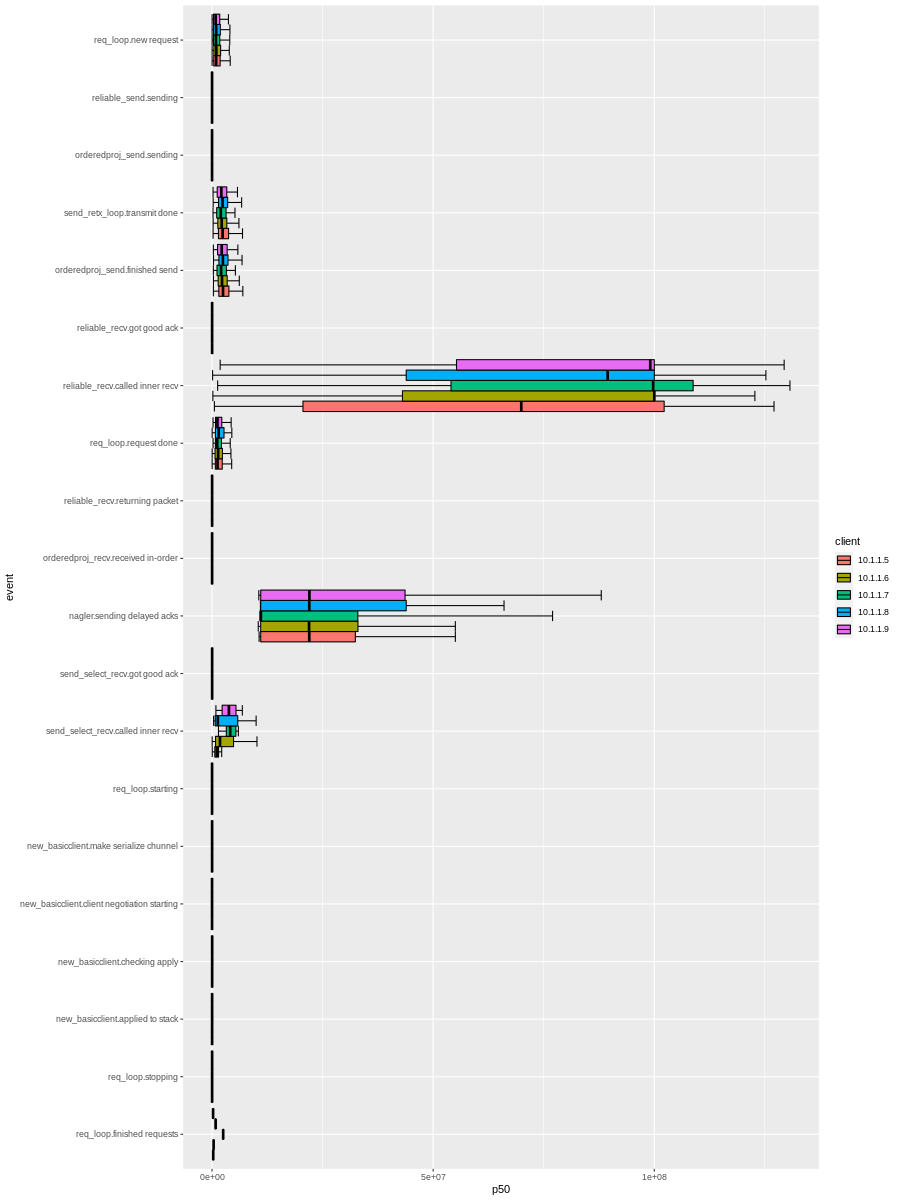

In [75]:
%%R -i df -w 900 -h 1200

library(ggplot2)
df$event <- reorder(df$event, df$cnt)
ggplot(df, aes(y = event, fill=client)) +
  geom_errorbar(aes(xmin=min, xmax=p95), position="dodge") +
  geom_crossbar(aes(xmin=p25, x=p50, xmax=p75), position="dodge")


In [77]:
sdf = None
for outdir in [f"kv-{c}" for c in commits]:
    for ns in num_shards:
        for o in ops:
            for st in shard_types:
                for c in client_concurrency:
                    sfn = f"{outdir}/{ns}-{st}shard-{o}-test-1000-{c}-0-kvserver.trace"
                    try:
                        file_df = pd.DataFrame.from_records(parse_trace(sfn))
                        if sdf is None:
                            sdf = file_df
                        else:
                            sdf = sdf.append(file_df)
                    except Exception as e:
                        print(f"skip {sfn}")
                        continue

sdf

,event,min,p25,p50,p75,p95,max,cnt
0,redis_insert.adding,17536,17663,17663,17663,17663,17663,1
1,redis_insert.done,274432,276479,276479,276479,276479,276479,1
2,process_nonces_connection.call recv(),3488,3519,3551,4223,4671,4671,6
3,server.start shard,18944,21503,23295,29183,34047,34047,6
4,server.start canonical server,999424,1003519,1003519,1003519,1003519,1003519,1
5,serve.connecting to shard,21632,54527,61695,67071,101887,101887,6
6,serve.client negotiation starting,32640,33023,38911,44543,44543,44543,6
7,serve.checking apply,11584,15167,17663,27263,39167,39167,12
8,serve.applied to stack,11776,12479,12927,23551,28415,28415,6
9,serve.make serialize chunnel,11648,12287,12287,24831,29055,29055,6


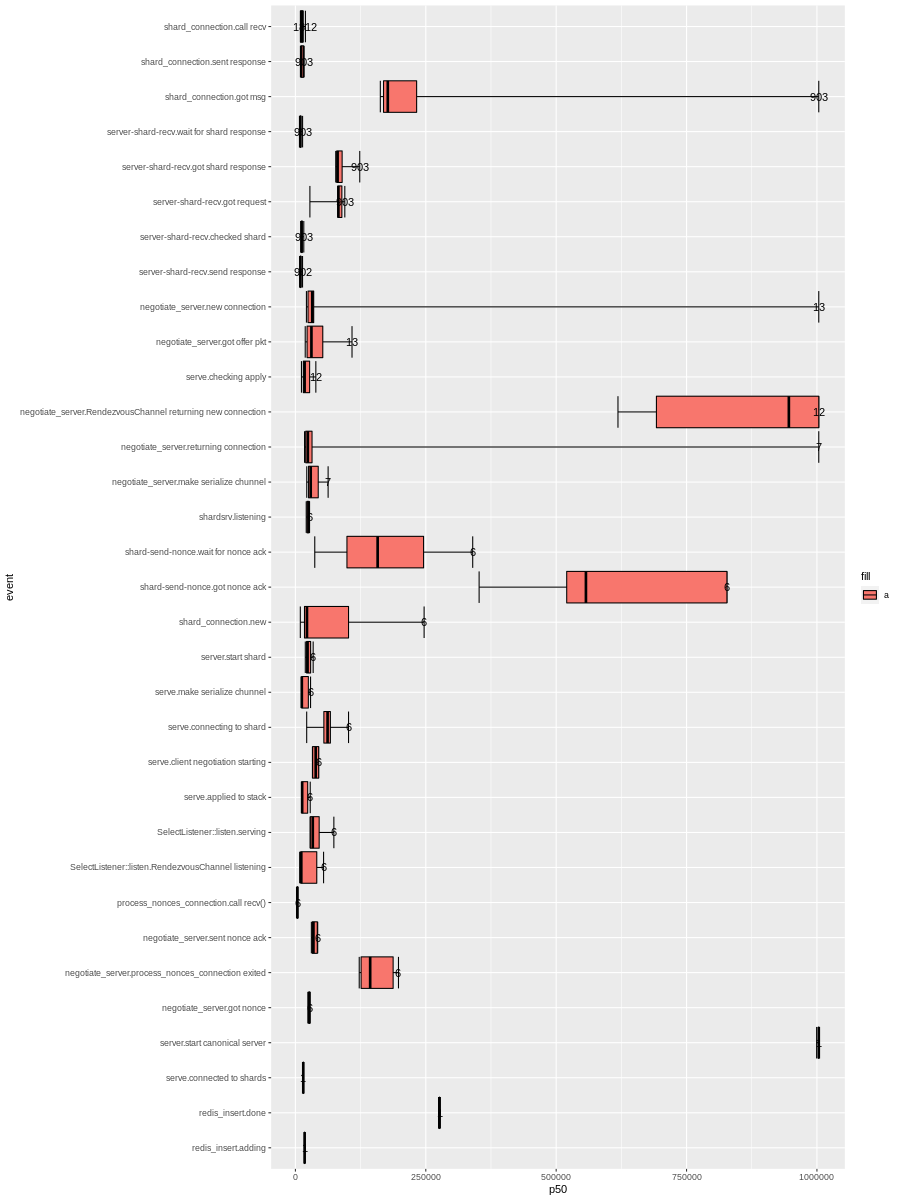

In [78]:
%%R -i sdf -w 900 -h 1200

library(ggplot2)

sdf$event <- reorder(sdf$event, sdf$cnt)

ggplot(sdf, aes(y = event, fill="a")) +
  geom_errorbar(aes(xmin=min, xmax=p95), position="dodge") +
  geom_crossbar(aes(xmin=p25, x=p50, xmax=p75), position="dodge") +
  geom_text(aes(label=cnt, x = p95, nudge_x=-1)) 
